# Claude / Gemini verifications

In [35]:
import private_info

In [4]:
!pip install anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.2/297.2 kB 1.8 MB/s eta 0:00:00


In [12]:
import pandas as pd
df = pd.read_csv("/content/label_training.csv")
df

,Unnamed: 0,id,title,abstract,label,aging,note
0,0,0,Hydrogel Microneedles with Programmed Mesophas...,Microneedle-based drug delivery offers an attr...,medical research,non-aging research,This is medical research on drug delivery tech...
1,1,1,Primary intestinal lymphangiectasia with lymph...,"Primary intestinal lymphangiectasia (PIL), als...",medical research,non-aging research,This is a case report of a rare disease in a y...
2,2,2,Hermansky-Pudlak Syndrome Complicated by Crohn...,ABSTRACT Hermansky-Pudlak syndrome (HPS) is a ...,medical research,non-aging research,This is a case report on rare immune disorders...
3,3,3,Performance Comparison of Liquid Chromatograph...,Kinase inhibitors are small-molecule drugs des...,medical research,non-aging research,This study evaluates drug monitoring methods i...
4,4,4,Prophylaxis vs preemptive therapy in preventio...,"Abstract Cytomegalovirus (CMV), the beta-human...",medical research,non-aging research,This is medical research on CMV prevention in ...
...,...,...,...,...,...,...,...
1994,1994,5903,Chapter: imaging of atrial and ventricular sep...,Septal defects together account for the majori...,medical research,non-aging research,The abstract discusses congenital heart defect...
1995,1995,12056,Managing Oral Mucositis in Patients With Cancer,Patients with oral mucositis (OM) have inflame...,medical research,non-aging research,The abstract discusses clinical interventions ...
1996,1996,10934,Intraoperative Magnetic Resonance Imaging–Guid...,Despite the most recent surgical aids and tool...,medical research,non-aging research,This study investigates surgical techniques an...
1997,1997,701,Increased Computed Tomography Utilization in t...,Our goal was to investigate trends in computed...,medical research,non-aging research,This is medical research on CT use and hospita...


In [27]:
import anthropic
import pandas as pd
import json

# initialize client
client = anthropic.Anthropic(api_key=private_info.claude_key)

# your prompt function
def create_prompt(title, abstract_str):
    prompt = f"""
        You are a classifier. I will give you an abstract and a title.

        Definitions:
        - "Medical research" refers to research that investigates human biology, disease, clinical interventions, health outcomes, or public health—typically conducted in the context of biomedical or health sciences.
        - "Aging research" refers to studies that explicitly examine biological, clinical, or systemic aspects of aging. This includes physiological aging, age-related disease, elder care models, or aging-targeted interventions. Do not classify research as aging-related merely because it involves older adults.

        Your tasks:
        1. Classify the content as one of: "medical research", "non-medical research", or "uncertain".
        2. Classify the content as one of: "aging research", "non-aging research", or "uncertain".
        3. Provide a short note (1 sentence, as short as possible) to justify both classifications.

        Output only a valid JSON object with these fields:
        - "label": medical classification
        - "aging": aging classification
        - "note": a one-sentence explanation

        Only return valid JSON. Abstract: {abstract_str}; Title: {title}
        """
    return prompt


# function to classify a single title+abstract
def classify_paper(title, abstract_str):
    prompt = create_prompt(title, abstract_str)
    message = client.messages.create(
        model="claude-sonnet-4-20250514",
        max_tokens=500,
        messages=[{"role": "user", "content": prompt}],
    )

    raw = message.content[0].text.strip()

    # remove Markdown code fences if they exist
    if raw.startswith("```"):
        raw = raw.strip("`")               # drop backticks
        raw = raw.replace("json", "", 1).strip()  # drop the 'json' tag if present

    try:
        return json.loads(raw)
    except Exception:
        return None

In [28]:
classify_paper(df.iloc[0].title, df.iloc[0].abstract)

{'label': 'medical research',
 'aging': 'non-aging research',
 'note': 'This study develops a drug delivery system for therapeutic agents through the skin, which is medical research, but does not examine aging-related biological processes or interventions.'}

In [31]:
from tqdm.notebook import tqdm
import random

def fill_missing_claude(df):
    for col in ["claude_label", "claude_aging", "claude_note"]:
        if col not in df.columns:
            df[col] = None

    missing_rows = df[df[["claude_label", "claude_aging", "claude_note"]].isnull().any(axis=1)]
    total = len(missing_rows)
    if total == 0:
        print("✅ All rows classified already.")
        return df

    for _ in tqdm(range(total), desc="Classifying with Claude"):
        missing_rows = df[df[["claude_label", "claude_aging", "claude_note"]].isnull().any(axis=1)]
        if missing_rows.empty:
            break

        idx = random.choice(missing_rows.index.tolist())
        row = df.loc[idx]

        result = classify_paper(row["title"], row["abstract"])
        if result:
            df.at[idx, "claude_label"] = result.get("label", "uncertain")
            df.at[idx, "claude_aging"] = result.get("aging", "uncertain")
            df.at[idx, "claude_note"]  = result.get("note", "parsing failed")

    return df

# Example usage:
df = fill_missing_with_claude(selected_df)

Classifying with Claude:   0%|          | 0/97 [00:00<?, ?it/s]

In [32]:
df.to_csv('selected_df.csv', index=False)

In [34]:
df

,Unnamed: 0,id,title,abstract,label,aging,note,claude_label,claude_aging,claude_note
0,1012,1012,Retinal vascular and structural changes are as...,Retinal imaging may serve as an alternative ap...,medical research,aging research,This is medical research on Alzheimer's diseas...,medical research,aging research,This is medical research investigating Alzheim...
1,1810,8054,Oxidative Stress Induced Damage and Early Sene...,Introduction. Senescent cells have been demons...,medical research,aging research,This is medical research investigating cellula...,medical research,aging research,This study investigates human pregnancy outcom...
2,1361,1361,Anthropometric indicators as predictors of dyn...,Aim: Anthropometry represents an alternative t...,medical research,aging research,This is medical research focused on muscle fit...,medical research,aging research,This study investigates dynapenia (muscle weak...
3,121,121,Laser fluorescence spectroscopy and optical ti...,There are currently no effective measures to c...,medical research,non-aging research,This study investigates diagnostic methods for...,medical research,non-aging research,This study investigates disease mechanisms and...
4,311,311,Improved risk stratification of patients with ...,Clinical scores and biomarkers improve risk st...,medical research,non-aging research,This study investigates biomarkers and risk st...,medical research,non-aging research,This study investigates biomarkers and clinica...
...,...,...,...,...,...,...,...,...,...,...
95,1941,13429,Modern approaches to the correction of age-rel...,The article is devoted to the literature revie...,medical research,aging research,The article reviews medical interventions for ...,medical research,aging research,This is medical research examining physiologic...
96,1666,10063,Aging changes of the testis in albino rat: lig...,Background: Aging has a deleterious effect on ...,medical research,aging research,This is medical research on aging-related chan...,medical research,aging research,This study investigates biological aging effec...
97,1718,12306,"The Million Person Study, whence it came and why",Purpose The study of low dose and low-dose rat...,medical research,non-aging research,This study investigates health effects of low-...,medical research,non-aging research,This is medical research studying radiation he...
98,1531,3131,Screening Value of Timed Up and Go Test for Fr...,Background We evaluated the validity of the Ti...,medical research,aging research,This study evaluates a clinical screening tool...,medical research,aging research,This is medical research validating a clinical...


In [33]:
from google.colab import files

files.download('selected_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
from google import genai
from pydantic import BaseModel
import pandas as pd
import random
from tqdm import tqdm
import private_info

# --- Pydantic schema for Gemini output ---
class Classification(BaseModel):
    label: str
    aging: str
    note: str

client = genai.Client(api_key=private_info.gemini_key)


# --- classify with Gemini (structured output) ---
def classify_paper_gemini(title, abstract_str):
    prompt = create_prompt(title, abstract_str)

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt,
        config={
            "response_mime_type": "application/json",
            "response_schema": Classification,
        },
    )

    return response.parsed  # returns a Classification object


# --- main loop with tqdm ---
def fill_missing_gemini(df):
    # init empty columns if not exist
    for col in ["gemini_label", "gemini_aging", "gemini_note"]:
        if col not in df.columns:
            df[col] = None

    missing_rows = df[df[["gemini_label", "gemini_aging", "gemini_note"]].isnull().any(axis=1)]
    total = len(missing_rows)
    if total == 0:
        print("✅ All rows classified already.")
        return df

    for _ in tqdm(range(total), desc="Classifying with Gemini"):
        missing_rows = df[df[["gemini_label", "gemini_aging", "gemini_note"]].isnull().any(axis=1)]
        if missing_rows.empty:
            break

        idx = random.choice(missing_rows.index.tolist())
        row = df.loc[idx]

        result = classify_paper_gemini(row["title"], row["abstract"])
        if result:
            df.at[idx, "gemini_label"] = result.label
            df.at[idx, "gemini_aging"] = result.aging
            df.at[idx, "gemini_note"]  = result.note

    return df

In [52]:
classify_paper_gemini(df.iloc[0].title, df.iloc[0].abstract)

Classification(label='medical research', aging='aging research', note="This study investigates Alzheimer's disease and potential biomarkers, classifying it as medical research, and specifically aging research due to AD being an age-related disease.")

In [54]:
df = fill_missing_gemini(df)

Classifying with Gemini: 100%|██████████| 91/91 [04:43<00:00,  3.11s/it]


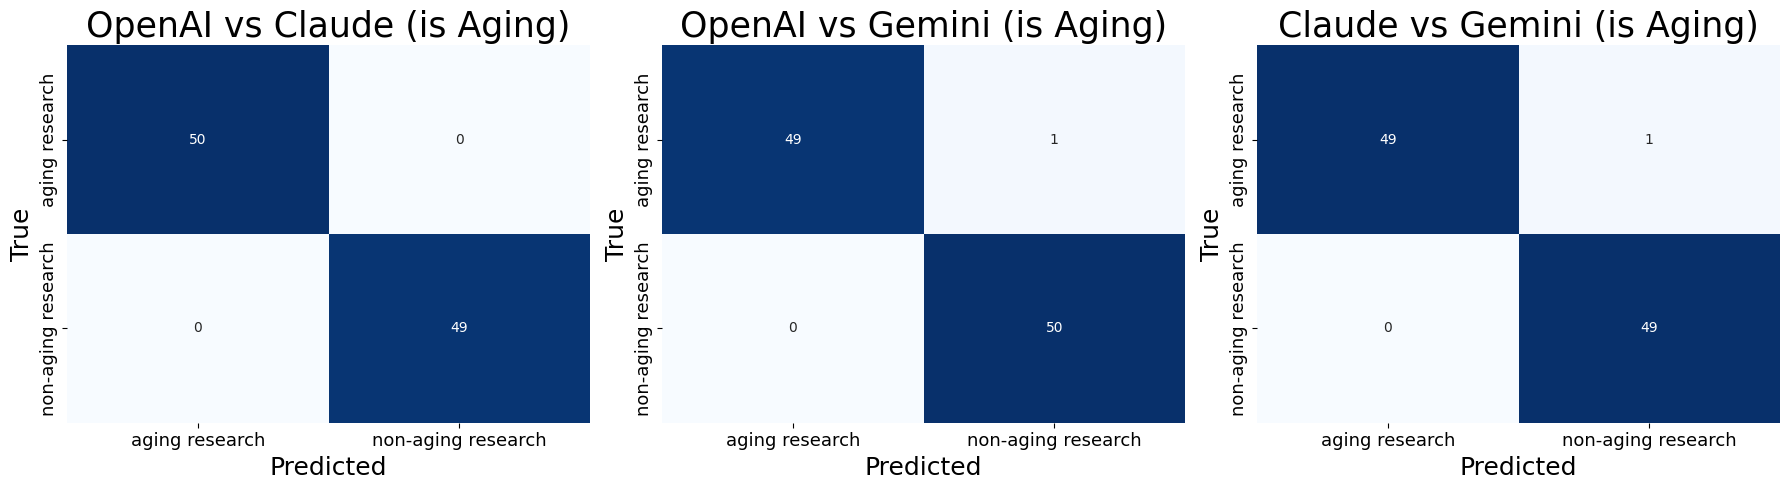

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(ax, y_true, y_pred, title):
    labels = ["aging research", "non-aging research"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues", ax=ax, cbar=False)
    ax.set_title(title, fontsize=25)
    ax.set_xlabel("Predicted", fontsize=18)
    ax.set_ylabel("True", fontsize=18)
    ax.tick_params(axis="x", labelsize=13)
    ax.tick_params(axis="y", labelsize=13)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_confusion(axes[0], df["aging"], df["claude_aging"], "OpenAI vs Claude (is Aging)")
plot_confusion(axes[1], df["aging"], df["gemini_aging"], "OpenAI vs Gemini (is Aging)")
plot_confusion(axes[2], df["claude_aging"], df["gemini_aging"], "Claude vs Gemini (is Aging)")

plt.tight_layout()
plt.show()
